In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split


In [4]:
building = pd.read_csv('data/building_dataset.csv')
building.drop(columns=['BuildingID', 'YearBuilt', 'RenewableContributionPercentage'], inplace=True)
building['BuildingType'] = building['BuildingType'].astype('category')
building['EnergySource'] = building['EnergySource'].astype('category')
building['RenewableType'] = building['RenewableType'].astype('category')
building.head()

,BuildingType,MonthlyElectricityConsumption_kWh,PeakUsageTime_Hour,RenewableCapacity_kWh,RenewableType,EnergySource,EnergyEfficiency_kWh_per_m2,WeatherData_Temperature_C,WeatherData_SolarIntensity_Hours,WeatherData_WindSpeed_km_h
0,Educational,673.62,8,3292.66,NaN,Electricity,21.15,12.51,5.44,71.64
1,Agricultural,294.60,10,0.00,Tidal,Coal,21.01,18.22,8.91,10.85
2,Retail,210.20,20,6483.89,Solar,Electricity,34.53,39.40,3.59,13.45
3,Commercial,174.14,5,12150.11,Wind,Biomass,48.66,17.97,3.65,40.85
4,Educational,61.27,23,3516.48,Solar,Electricity,25.46,16.18,8.11,72.20


In [5]:
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9482 entries, 0 to 9481
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   BuildingType                       9482 non-null   category
 1   MonthlyElectricityConsumption_kWh  9482 non-null   float64 
 2   PeakUsageTime_Hour                 9482 non-null   int64   
 3   RenewableCapacity_kWh              9482 non-null   float64 
 4   RenewableType                      8914 non-null   category
 5   EnergySource                       9482 non-null   category
 6   EnergyEfficiency_kWh_per_m2        9482 non-null   float64 
 7   WeatherData_Temperature_C          9482 non-null   float64 
 8   WeatherData_SolarIntensity_Hours   9482 non-null   float64 
 9   WeatherData_WindSpeed_km_h         9165 non-null   float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 547.4 KB


In [6]:
X = building.drop(columns=['MonthlyElectricityConsumption_kWh'])
y = building['MonthlyElectricityConsumption_kWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [7]:
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [8]:
params = {
    'objective':'reg:squarederror',
    'eta':0.01,
}

result = xgb.cv(dtrain=dtrain, params=params, nfold=5, as_pandas=True, seed=42, early_stopping_rounds=500, num_boost_round=10000)
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,403.076887,6.086751,402.697801,23.617254
1,400.065825,6.019144,399.869582,23.466564
2,397.089797,5.952162,397.078700,23.318546
3,394.149562,5.885821,394.321122,23.170865
4,391.245827,5.819896,391.594420,23.029202
...,...,...,...,...
291,161.153204,2.021010,219.600555,8.742075
292,161.004736,2.002161,219.605782,8.747661
293,160.849192,2.017733,219.593570,8.734118
294,160.683204,1.995135,219.607140,8.730357


In [9]:
model = xgb.train(params, dtrain, result.shape[0])

In [10]:
shap_values_xgb = model.predict(dtrain, pred_contribs=True)

In [11]:
shap_values_xgb = shap_values_xgb[:, :-1]

pd.DataFrame(shap_values_xgb, columns=X_train.columns.tolist()).head()

,BuildingType,PeakUsageTime_Hour,RenewableCapacity_kWh,RenewableType,EnergySource,EnergyEfficiency_kWh_per_m2,WeatherData_Temperature_C,WeatherData_SolarIntensity_Hours,WeatherData_WindSpeed_km_h
0,-180.525085,0.196346,-0.692222,-1.300251,-0.012989,-50.829693,0.323189,0.083971,-0.326869
1,72.709213,-1.955835,2.403283,-3.239368,-1.208092,-180.301788,0.195035,-2.663932,-1.068243
2,107.230965,-4.966089,0.587786,7.170833,-0.581249,42.517410,-1.239461,-1.267960,0.494829
3,77.095093,0.123019,12.409715,0.378155,-0.861141,-108.270149,0.516710,-0.672880,0.224209
4,71.274513,-3.456099,-0.988126,2.621844,0.305969,-135.996796,0.461466,-0.165432,0.755237


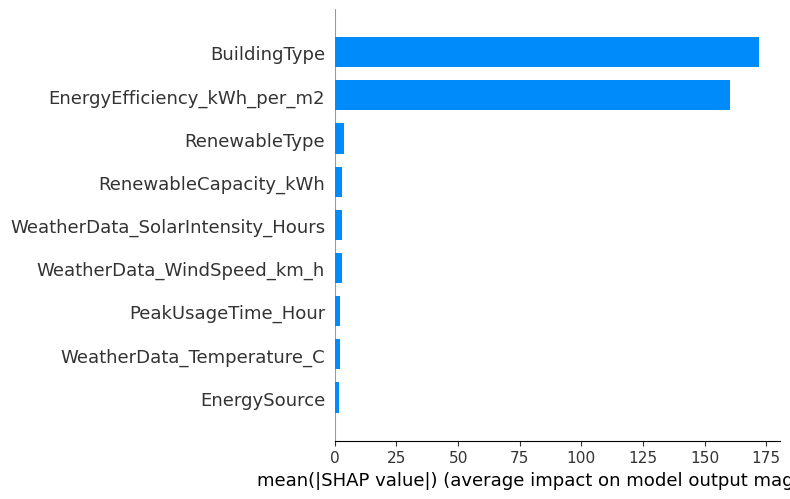

In [12]:
shap.summary_plot(
    shap_values_xgb, X_train, feature_names=X_train.columns, plot_type="bar"
)

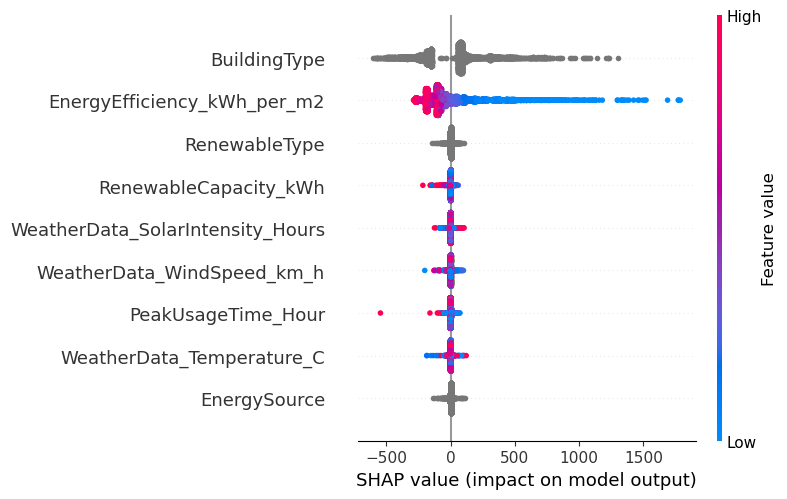

In [13]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns);

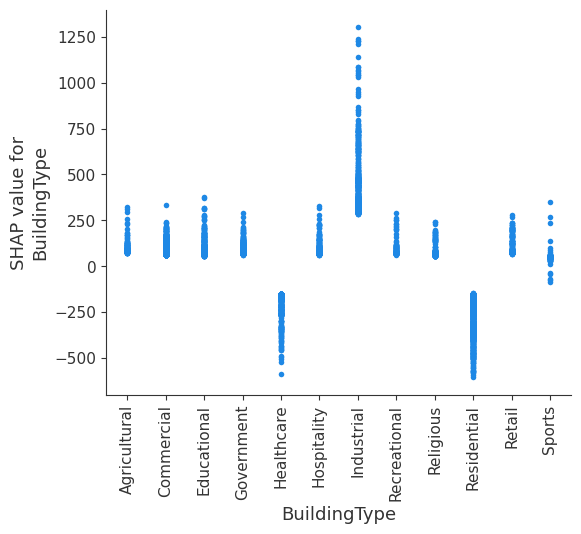

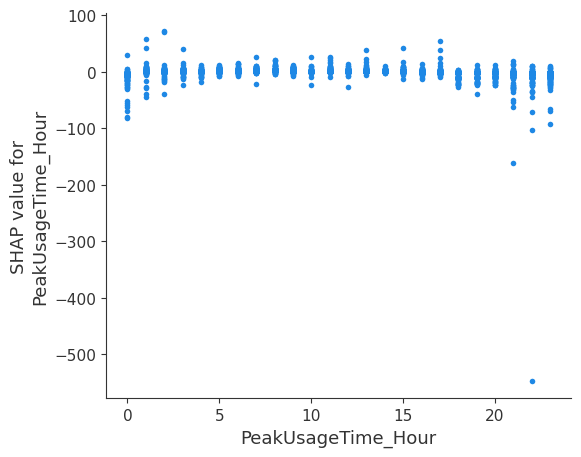

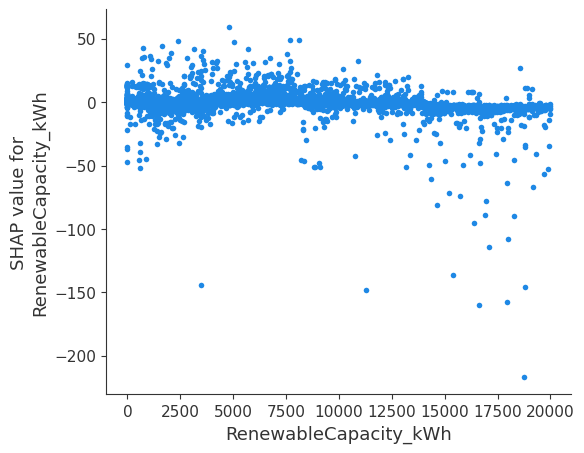

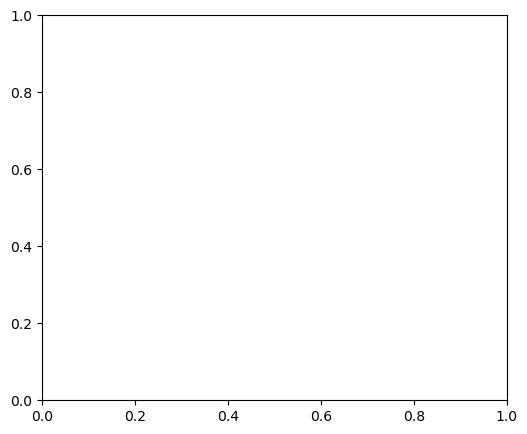

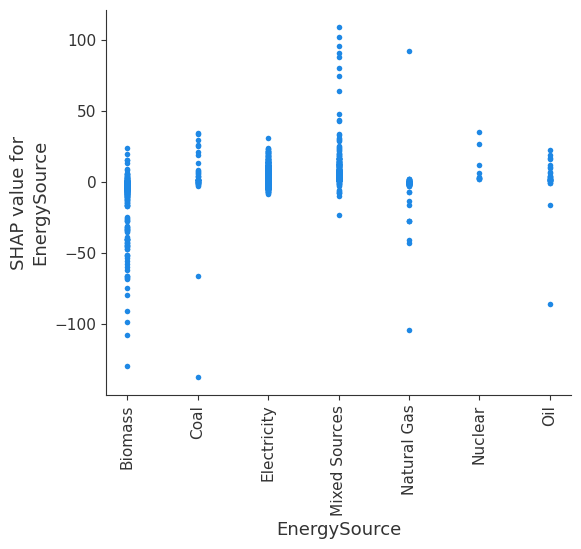

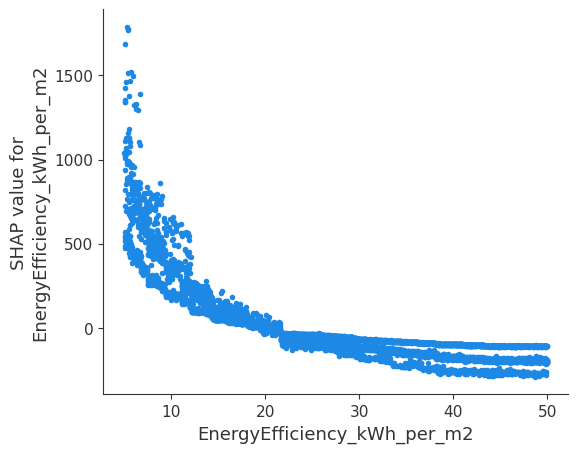

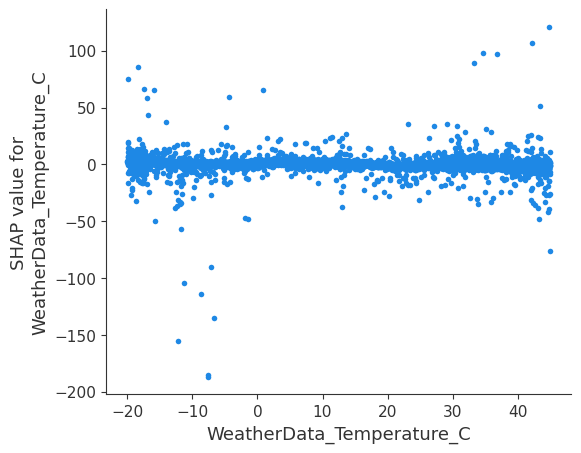

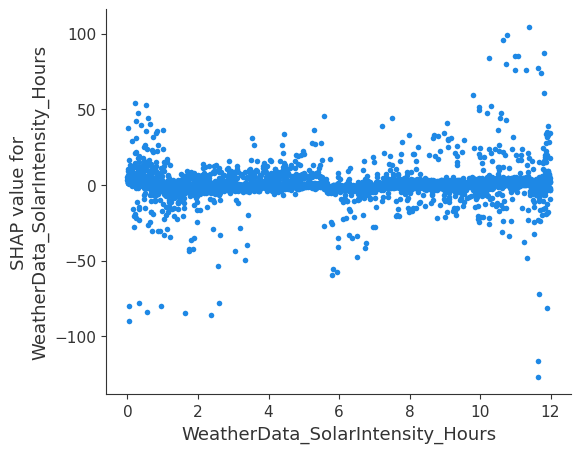

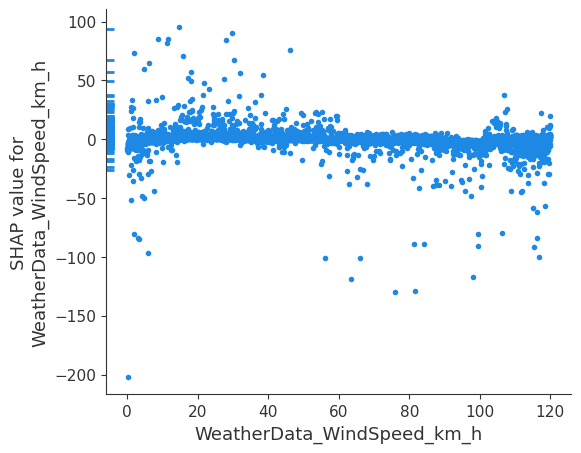

In [14]:
for x in X_train.columns:
    try:
        shap.dependence_plot(x, shap_values_xgb, X_train, interaction_index=None)
    except:
        pass

In [18]:
model.save_model('model/model.json')

In [20]:
import joblib

joblib.dump(X, 'model/df.pkl')

['model/df.pkl']